In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import sys
import datetime
import random
import warnings

# Functions
sys.path.insert(0, './implementations/')
from implementations import *
from preprocessing import *
from pca import *
from plot import *
from helpers import *

# Autoreload
%load_ext autoreload
%autoreload 2

# Set random seed
np.random.seed(1)

In [2]:
# Load data and create optimized dataset (includes interaction terms and degree 3)

# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_= process_data(data_raw, t_data_raw, feature_filtering = False,
                                      replace = 'median', standardize=False, remove_outlier=True)

# Create partitions for dataset
y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)
# Initialize boxplots values
boxplots = []
test_accuracies = []

Finding and replacing outliers by column mean
Replacing NaN points with feature median value


# Linear Regression: Gradient Descent

In [3]:
# Initialize w vector
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6

# Perform linear regression by gradient descent with cross validation (k=4)
_, _, _, _, _, accuracies = least_squares_GD(y_train, X_train, y_test, X_train_std,
                                             initial_w, gamma = 0.005, k=k_, max_iters = 500)
boxplots.append(accuracies)

# Perform linear regression by gradient descent on whole training set
_, _, _, test_accuracy, _ = least_squares_GD(y_train, X_train_std, y_test, X_test_std,
                                             initial_w, gamma = 0.005, k=0, max_iters = 500)

# Use w to predict unseen test set labels

test_accuracies.append(test_accuracy[-1])

# Write results to file

file_object = open('cv_results', 'w')
file_object.write('fold1, fold2, fold3, fold4, test_set \n')
acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy[-1]) + '\n'
file_object.write(acc_s + ', ' + acc_t)


87

# Linear Regression: Stochastic Gradient Descent 

In [4]:
# # Initialize w vector
# initial_w = np.random.rand(X_train_std.shape[1])
# k_ = 6

# cv_accuracies, test_accuracy = do_cross_val('linear_regression_SGD',
#                                             k_, initial_w, y_train,
#                                             X_train, y_test, X_train_std,
#                                             X_test_std)
# boxplots.append(cv_accuracies)
# test_accuracies.append(test_accuracy)

# # Write results to file

# acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
# acc_t = str(test_accuracy) + '\n'
# file_object.write(acc_s + ', ' + acc_t)

# Linear Regression: Direct Least Squares

In [5]:
k_ = 6

# Perform linear regression by direct least squares with cross validation (k=4)
_, _, _, _, accuracies = least_squares(y_train, X_train, k_)
boxplots.append(accuracies)

# Perform linear regression by direct least squares on whole training set
w = least_squares(y_train, X_train_std, k=0)

# Use w to predict unseen test set labels
test_pred_lab = predict_labels(w, X_test_std)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
test_accuracies.append(test_accuracy)

# Write results to file

acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)


88

# Linear Regression: Regularized

In [6]:
# Search for optimal lambda value to implement for cross validation

lambdas = np.logspace(-7, 0, 30)
rmse_tr = []
rmse_ts = []
pred_tr = []
pred_ts = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train_std, lambda_)
    
#     rmse_tr.append(np.sqrt(2 * compute_loss(y_train, X_train, w)))
    pred_tr.append(pred_accuracy(predict_labels(w, X_train_std), y_train))
#     rmse_ts.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_ts.append(pred_accuracy(predict_labels(w, X_test_std), y_test))
    
selected_lambda = lambdas[np.argmax(pred_ts)]

k_ = 6

# Perform regularized linear regression with cross validation (k=4)
# Note that the value for lambda that is selected for this cross validation assessment it taken 
# from the above grid search which provided the best accuracies scores for the test set.

cv_accuracies, test_accuracy = do_cross_val('ridge_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std, lambda_ = selected_lambda)
boxplots.append(cv_accuracies)
test_accuracies.append(test_accuracy)

# Write results to file

acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)

88

# Logistic Regression

In [7]:
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6

# Perform logistic regression with Newton's Method
cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)
boxplots.append(cv_accuracies)
test_accuracies.append(test_accuracy)

# Write results to file

acc_s = str(cv_accuracies[0]) + ', ' + str(cv_accuracies[1]) + ', ' + str(cv_accuracies[2]) + ', ' + str(cv_accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)
file_object.close()

# Boxplots for Learning Algorithm

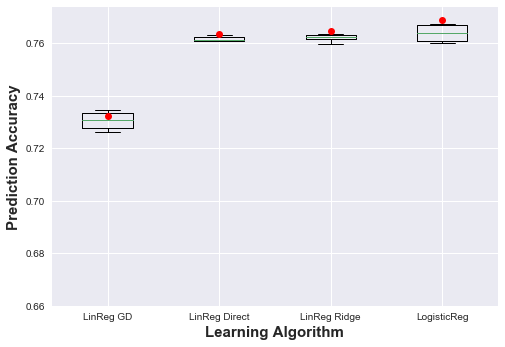

In [8]:
# Create boxplots
labels = ['LinReg GD','LinReg Direct','LinReg Ridge','LogisticReg']
boxplotter(boxplots, test_accuracies, labels, 'Learning Algorithm', 'Prediction Accuracy', 'LearningAlgs.png')


# Logistic Regression with Varying Degrees and Interaction Terms

In [9]:
# Load data and create optimized dataset (includes interaction terms and degree 3)

# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_= process_data(data_raw, t_data_raw, feature_filtering = False,
                                      replace = 'median', standardize=False, remove_outlier=True)


Finding and replacing outliers by column mean
Replacing NaN points with feature median value


**Without addition of features by degree 2 or interaction terms**

In [10]:
boxplots_log = []
test_accuracies_log = []
y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = False,
                                                                   degree = 0)

# Perform logistic regression with Newton's Method
cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)
boxplots_log.append(cv_accuracies)
test_accuracies_log.append(test_accuracy)

**With degree 2 features but no interactive terms**

In [11]:
y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = False,
                                                                   degree = 2)

# Perform logistic regression with Newton's Method
cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)
boxplots_log.append(cv_accuracies)
test_accuracies_log.append(test_accuracy)

**With degree 3 without interaction terms**

In [12]:
y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = False,
                                                                   degree = 3)
# Perform logistic regression with Newton's Method
cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)
boxplots_log.append(cv_accuracies)
test_accuracies_log.append(test_accuracy)

**With degree 2 and interaction terms**

In [13]:
y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)
# Perform logistic regression with Newton's Method
cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)
boxplots_log.append(cv_accuracies)
test_accuracies_log.append(test_accuracy)

**With degree 3 and interaction terms**

In [14]:
y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 3)
# Perform logistic regression with Newton's Method
cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)
boxplots_log.append(cv_accuracies)
test_accuracies_log.append(test_accuracy)

# Create Boxplots

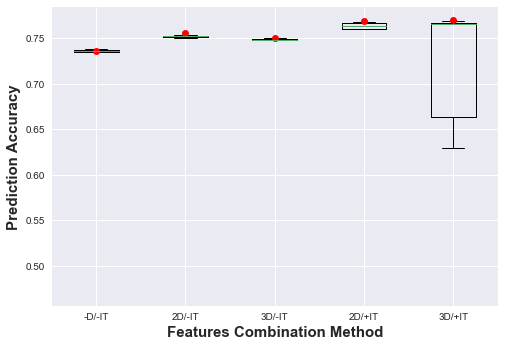

In [15]:
# Create boxplots

labels=['-D/-IT', '2D/-IT','3D/-IT','2D/+IT','3D/+IT']
boxplotter(boxplots_log, test_accuracies_log, labels,
           'Features Combination Method', 'Prediction Accuracy', 'FeatureExpansion.png')

# Testing Different Preprocessing Methods

**With feature filtering. Replace by Mean**

In [16]:
# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_ = process_data(data_raw, t_data_raw,
                                      feature_filtering = True,
                                      replace = 'mean', remove_outlier=False, standardize=False)

y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)
boxplots_preprocessing = []
test_accuracies_preprocessing = []

Filtering features
Replacing NaN points with feature mean value


In [17]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)

boxplots_preprocessing.append(cv_accuracies)
test_accuracies_preprocessing.append(test_accuracy)

**With feature filtering. Replace by median**

In [18]:
# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_ = process_data(data_raw, t_data_raw, feature_filtering = True,
                              replace = 'median', remove_outlier=False, standardize=False)

y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)

Filtering features
Replacing NaN points with feature median value


In [19]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)

boxplots_preprocessing.append(cv_accuracies)
test_accuracies_preprocessing.append(test_accuracy)

**With feature filtering. Replace by zero**

In [20]:
# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_ = process_data(data_raw, t_data_raw, feature_filtering = True,
                                      replace = 'zero', remove_outlier=False, standardize=False)

y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)

Filtering features
Replacing NaN points with zeros


In [21]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)

boxplots_preprocessing.append(cv_accuracies)
test_accuracies_preprocessing.append(test_accuracy)

**Without feature filtering. Remove outliers and replace by mean**

In [22]:
# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_ = process_data(data_raw, t_data_raw, feature_filtering = False,
                                      replace = 'mean', remove_outlier=True, standardize=False)

y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)

Finding and replacing outliers by column mean
Replacing NaN points with feature mean value


In [23]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)

boxplots_preprocessing.append(cv_accuracies)
test_accuracies_preprocessing.append(test_accuracy)

**Without feature filtering. Remove outliers. Replace with median**

In [24]:
# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_ = process_data(data_raw, t_data_raw, feature_filtering = False,
                                      replace = 'median', remove_outlier=True, standardize=False)

y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)

Finding and replacing outliers by column mean
Replacing NaN points with feature median value


In [25]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)

boxplots_preprocessing.append(cv_accuracies)
test_accuracies_preprocessing.append(test_accuracy)

**Without feature removal. Remove outliers. Replace by zero**

In [26]:
# Set random seed
np.random.seed(0)

(labels, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

data_, data_t_ = process_data(data_raw, t_data_raw, feature_filtering = False,
                                      replace = 'zero', remove_outlier=True, standardize=False)

y_train, X_train, y_test, X_train_std, X_test_std = create_dataset(data_,
                                                                   labels,
                                                                   interact = True,
                                                                   degree = 2)

Finding and replacing outliers by column mean
Replacing NaN points with zeros


In [27]:
# Initialize parameters
initial_w = np.random.rand(X_train_std.shape[1])
k_ = 6
thresh = 0.5

# Perform logistic regression with Newton's Method

cv_accuracies, test_accuracy = do_cross_val('logistic_regression',
                                            k_, initial_w, y_train,
                                            X_train, y_test, X_train_std,
                                            X_test_std)

boxplots_preprocessing.append(cv_accuracies)
test_accuracies_preprocessing.append(test_accuracy)

# Create Boxplots

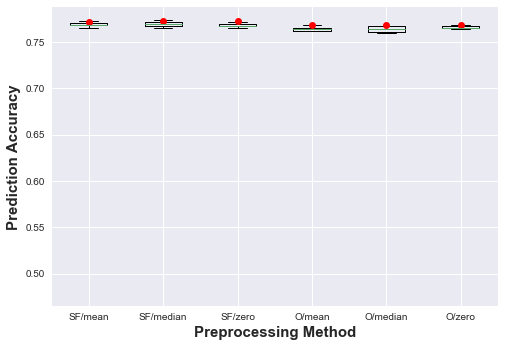

In [28]:
# Create boxplots

labels=['SF/mean', 'SF/median','SF/zero','O/mean','O/median', 'O/zero']
boxplotter(boxplots_preprocessing, test_accuracies_preprocessing, labels,
           'Preprocessing Method', 'Prediction Accuracy', 'Preprocessing.png')
